<a href="https://colab.research.google.com/github/arham-habib/hedged/blob/main/Synthetic_Steel_Futures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic steel futures

### Problem statement: 

**Steel prices have experienced increased volatility in recent years**. Consequently, construction companies cannot properly hedge their costs. Many contractors don't have the financial expertise to hedge construction materials.

Further, just-in-time manufacturing means traditional forward contracts might not be sufficient. For example, a contractor might not know the amount of steel it needs three months in the future during June, as this depends on how fast a project has progressed and how many new projects it has in the wings. Further, they might not want to stockpile steel, which exposes them to **inventory risk** and **decreases its ROA**. 

### Solution: 

Using publicly traded futures on the Chicago Mercantile Exchange, we will recreate the **Producer Price Index by Industry: Fabricated Structural Metal Manufacturing: Fabricated Structural Iron and Steel for Commercial, Residential, Institutional, and Public Buildings**. This data is accessible on the FRED database (code WPU101). For now, we will focus on futures contracts accessible in the US – including hot rolled coil and steel scrap

###1: Acquire data

We will use monthly data, as we are limited by the frequency of the Producer Price Index (and weekly/daily data is subject to noise). 



In [1]:
import pandas as pd

ppi_fabricated_steel = pd.read_csv("https://raw.githubusercontent.com/arham-habib/hedged/main/Data/PPI%20Fabricated%20Structural%20Metal.csv")
hrc = pd.read_csv("https://raw.githubusercontent.com/arham-habib/hedged/main/Data/U.S.%20Midwest%20Domestic%20Hot-Rolle%20(HRC%3DF).csv")
steel_scrap = pd.read_csv("https://raw.githubusercontent.com/arham-habib/hedged/main/Data/Steel%20Scrap%20Futures%20Historical%20Data.csv")

print(ppi_fabricated_steel.head())
print(hrc.head())
print(steel_scrap.head())

         DATE  PCU33231233231212
0  2011-06-01              100.0
1  2011-07-01              101.2
2  2011-08-01              100.7
3  2011-09-01              100.6
4  2011-10-01              100.9
         Date  Open  High   Low  Close*  Adj Close** Volume
0  2023-03-01  1002  1065  1002    1065         1065    209
1  2023-02-01   786  1070   785    1054         1054   3237
2  2022-12-01   656   750   650     744          744   1750
3  2022-10-31   713   713   645     655          655   2340
4  2022-09-30   770   790   682     713          713   3085
         Date   Price   Open   High    Low   Vol. Change %
0  03/01/2023  460.00  468.0  468.0  468.0    NaN    6.76%
1  02/01/2023  430.88  430.0  430.0  430.0  9.31K    4.33%
2  01/01/2023  413.00  411.5  411.5  411.5  6.56K    6.88%
3  12/01/2022  386.41  381.0  381.0  381.0  3.88K   10.86%
4  11/01/2022  348.56  355.5  355.5  355.5  2.81K   -4.73%


Cleaning the data by reformatting the date columns and renaming the desired index. 

In [2]:
ppi_fabricated_steel = ppi_fabricated_steel.rename(columns={"PCU33231233231212": "ppi", "DATE": "Date"})
hrc = hrc.rename(columns={"Adj Close**": "price.hrc"})
steel_scrap = steel_scrap.rename(columns={"Price": "price.scrap"})

# hrc['Date'] = pd.to_datetime(hrc['Date'], format='%m/%d/%y').dt.strftime('%Y-%m-%d'), now unnecessary by pre-processing data
steel_scrap['Date'] = pd.to_datetime(steel_scrap['Date']).dt.strftime('%Y-%m-%d')

print(ppi_fabricated_steel.head(2))
print(hrc.head(2))
print(steel_scrap.head(2))

         Date    ppi
0  2011-06-01  100.0
1  2011-07-01  101.2
         Date  Open  High   Low  Close*  price.hrc Volume
0  2023-03-01  1002  1065  1002    1065       1065    209
1  2023-02-01   786  1070   785    1054       1054   3237
         Date  price.scrap   Open   High    Low   Vol. Change %
0  2023-03-01       460.00  468.0  468.0  468.0    NaN    6.76%
1  2023-02-01       430.88  430.0  430.0  430.0  9.31K    4.33%


Plot the data and observe preliminary similarities and differences: 

In [3]:
# change the date to a pandas datetime object
ppi_fabricated_steel['Date'] = pd.to_datetime(ppi_fabricated_steel['Date'])
hrc['Date'] = pd.to_datetime(hrc['Date'])
steel_scrap['Date'] = pd.to_datetime(steel_scrap['Date'])

# set indeces
ppi_fabricated_steel = ppi_fabricated_steel.set_index('Date')
hrc = hrc.set_index('Date')
steel_scrap = steel_scrap.set_index('Date')

Plot PPI index: 

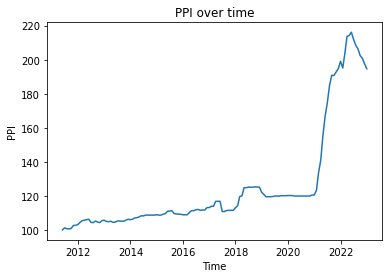

In [4]:
import matplotlib.pyplot as plt

# create a line plot of the data
plt.plot(ppi_fabricated_steel.index, ppi_fabricated_steel['ppi'])

# set the title and axis labels
plt.title('PPI over time')
plt.xlabel('Time')
plt.ylabel('PPI')

# show the plot
plt.show()


Plot HRC futures: 

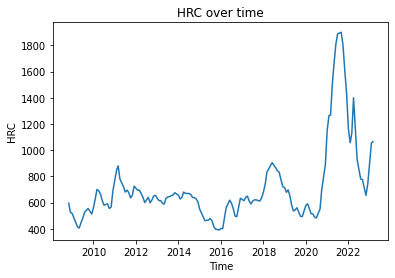

In [5]:
# create a line plot of the data
plt.plot(hrc.index, hrc['price.hrc'])

# set the title and axis labels
plt.title('HRC over time')
plt.xlabel('Time')
plt.ylabel('HRC')

# show the plot
plt.show()


Plot steel scrap futures: 

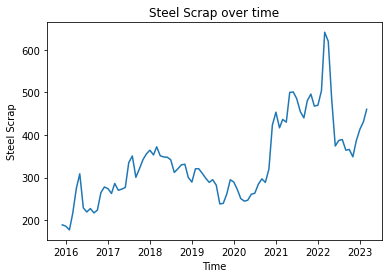

In [6]:
# create a line plot of the data
plt.plot(steel_scrap.index, steel_scrap['price.scrap'])

# set the title and axis labels
plt.title('Steel Scrap over time')
plt.xlabel('Time')
plt.ylabel('Steel Scrap')

# show the plot
plt.show()


Merge the data based on the date, with 2 day tolerance:

In [7]:
# sort the data
ppi_fabricated_steel = ppi_fabricated_steel.sort_values(by='Date')
hrc = hrc.sort_values(by='Date')
steel_scrap = steel_scrap.sort_values(by='Date')


# merge the data
merged_df = pd.merge_asof(ppi_fabricated_steel, hrc, on='Date', tolerance=pd.Timedelta('2 days'))
merged_df = pd.merge_asof(merged_df, steel_scrap, on='Date', tolerance=pd.Timedelta('2 days'))
merged_df = merged_df.dropna()
merged_df = merged_df[['Date', 'ppi', 'price.hrc', 'price.scrap']]
print(merged_df.head())

         Date    ppi  price.hrc  price.scrap
54 2015-12-01  109.2      391.0       188.95
56 2016-02-01  108.9      402.0       177.05
57 2016-03-01  108.9      480.0       216.19
58 2016-04-01  110.3      560.0       274.19
60 2016-06-01  111.3      618.0       228.73


Plot the data on one graph and calculate correlation: 

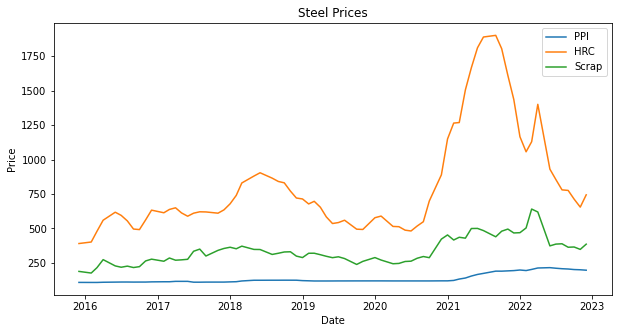

In [8]:
import matplotlib.pyplot as plt

# set the figure size
plt.figure(figsize=(10, 5))

# plot the 'ppi', 'price.hrc', and 'price.scrap' columns on the same graph
plt.plot(merged_df['Date'], merged_df['ppi'], label='PPI')
plt.plot(merged_df['Date'], merged_df['price.hrc'], label='HRC')
plt.plot(merged_df['Date'], merged_df['price.scrap'], label='Scrap')

# add axis labels and a title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Steel Prices')

# add a legend
plt.legend()

# display the plot
plt.show()

Add the lags, because fluctuations in earlier periods might affect later periods: 

In [9]:
# add lagged columns for 'price.hrc'
merged_df['price.hrc_lag1'] = merged_df['price.hrc'].shift(1)
merged_df['price.hrc_lag2'] = merged_df['price.hrc'].shift(2)
merged_df['price.hrc_lag3'] = merged_df['price.hrc'].shift(3)
merged_df['price.hrc_lag4'] = merged_df['price.hrc'].shift(4)

# add lagged columns for 'price.scrap'
merged_df['price.scrap_lag1'] = merged_df['price.scrap'].shift(1)
merged_df['price.scrap_lag2'] = merged_df['price.scrap'].shift(2)
merged_df['price.scrap_lag3'] = merged_df['price.scrap'].shift(3)
merged_df['price.scrap_lag4'] = merged_df['price.scrap'].shift(4)

# add one lag for ppi
merged_df['ppi_lag1'] = merged_df['ppi'].shift(1)


In [10]:
# correlations
print(merged_df.corr())

                       ppi  price.hrc  price.scrap  price.hrc_lag1  \
ppi               1.000000   0.591374     0.713129        0.666826   
price.hrc         0.591374   1.000000     0.827060        0.959735   
price.scrap       0.713129   0.827060     1.000000        0.779331   
price.hrc_lag1    0.666826   0.959735     0.779331        1.000000   
price.hrc_lag2    0.734209   0.891555     0.761155        0.960016   
price.hrc_lag3    0.788246   0.807231     0.768990        0.891485   
price.hrc_lag4    0.831077   0.714116     0.769326        0.807246   
price.scrap_lag1  0.764996   0.807197     0.890198        0.830045   
price.scrap_lag2  0.811331   0.729989     0.777159        0.807829   
price.scrap_lag3  0.840972   0.661004     0.742940        0.731610   
price.scrap_lag4  0.861186   0.602444     0.718022        0.662571   
ppi_lag1          0.993562   0.516796     0.662909        0.608865   

                  price.hrc_lag2  price.hrc_lag3  price.hrc_lag4  \
ppi                  

We'll take the log_diff of the three relevant prices. This will make the time series stationary, allowing us to use linear regression.

In [ ]:
import numpy as np

log_diff_df = pd.DataFrame(merged_df['Date'])
log_diff_df['log_diff_price_hrc'] = np.log(merged_df['price.hrc']).diff()
log_diff_df['log_diff_price_scrap'] = np.log(merged_df['price.scrap']).diff()
log_diff_df['log_diff_ppi'] = np.log(merged_df['ppi']).diff()

# drop earliest date with no prior change
log_diff_df = log_diff_df.dropna()


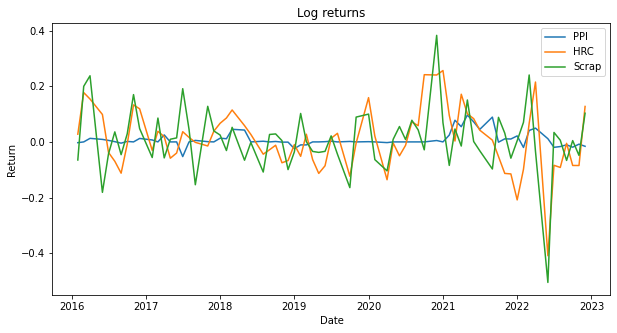

In [ ]:
import matplotlib.pyplot as plt

# set the figure size
plt.figure(figsize=(10, 5))

# plot the 'ppi', 'price.hrc', and 'price.scrap' columns on the same graph
plt.plot(log_diff_df['Date'], log_diff_df['log_diff_ppi'], label='PPI')
plt.plot(log_diff_df['Date'], log_diff_df['log_diff_price_hrc'], label='HRC')
plt.plot(log_diff_df['Date'], log_diff_df['log_diff_price_scrap'], label='Scrap')

# add axis labels and a title
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Log returns')

# add a legend
plt.legend()

# display the plot
plt.show()

In [ ]:
# Add the same lags: 

log_diff_df['log_diff_price_hrc_lag1'] = log_diff_df['log_diff_price_hrc'].shift(1)
log_diff_df['log_diff_price_hrc_lag2'] = log_diff_df['log_diff_price_hrc'].shift(2)
log_diff_df['log_diff_price_hrc_lag3'] = log_diff_df['log_diff_price_hrc'].shift(3)
log_diff_df['log_diff_price_hrc_lag4'] = log_diff_df['log_diff_price_hrc'].shift(4)

log_diff_df['log_diff_price_scrap_lag1'] = log_diff_df['log_diff_price_scrap'].shift(1)
log_diff_df['log_diff_price_scrap_lag2'] = log_diff_df['log_diff_price_scrap'].shift(2)
log_diff_df['log_diff_price_scrap_lag3'] = log_diff_df['log_diff_price_scrap'].shift(3)
log_diff_df['log_diff_price_scrap_lag4'] = log_diff_df['log_diff_price_scrap'].shift(4)

In [ ]:
# drop the NAs
merged_df = merged_df.dropna()
log_diff_df = log_diff_df.dropna()

print(log_diff_df.head())
print(merged_df.head())

         Date  log_diff_price_hrc  log_diff_price_scrap  log_diff_ppi  \
61 2016-07-01           -0.037927             -0.042831      0.005376   
62 2016-08-01           -0.069593              0.036032      0.000893   
63 2016-09-01           -0.112392             -0.045845     -0.004474   
64 2016-10-01           -0.008097              0.028977      0.001792   
65 2016-11-01            0.133023              0.169987      0.000000   

    log_diff_price_hrc_lag1  log_diff_price_hrc_lag2  log_diff_price_hrc_lag3  \
61                 0.098552                 0.154151                 0.177334   
62                -0.037927                 0.098552                 0.154151   
63                -0.069593                -0.037927                 0.098552   
64                -0.112392                -0.069593                -0.037927   
65                -0.008097                -0.112392                -0.069593   

    log_diff_price_hrc_lag4  log_diff_price_scrap_lag1  \
61              

### 2: Linear Regression (the naïve approach)

Now that we have a dataframe with the returns of each of the assets month to month, let's run a linear regression and analyze the results. Let's start with the non-stationary time series of price (I don't expect these to be useful except as a baseline, so I won't even split into test/train yet):

In [ ]:
import statsmodels.api as sm

# set y variable
y = merged_df['ppi']

# Define x variables
x_cols = [col for col in merged_df.columns if col not in ['ppi', 'Date']]
x = merged_df[x_cols]

# Add constant to x variables
x = sm.add_constant(x)

# Fit linear regression model
model = sm.OLS(y, x).fit()

# Calculate MSE
y_pred = model.predict(x)
mse = mean_squared_error(y, y_pred)

# Print model summary and MSE
print(model.summary())
print('MSE:', mse)

                            OLS Regression Results                            
Dep. Variable:                    ppi   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     29.95
Date:                Mon, 13 Mar 2023   Prob (F-statistic):           2.57e-19
Time:                        14:45:02   Log-Likelihood:                -280.51
No. Observations:                  69   AIC:                             583.0
Df Residuals:                      58   BIC:                             607.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               34.8555      9.868  

As expected, this is not a very robust model (the only significant term is the constant), likely due to multicollinearity and because linear regression assumes the time series is stationary. We'll plot this, and then let's try the same process on the log_return time series, and then start experimenting with regularization. 

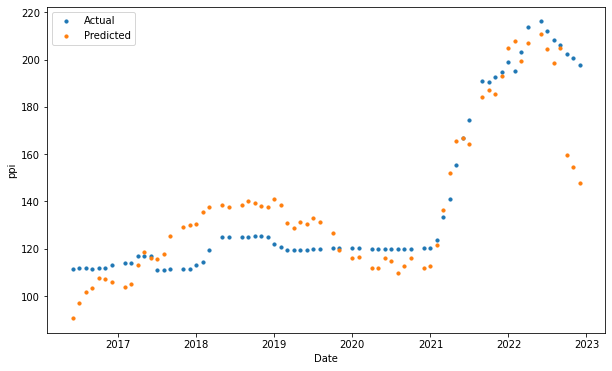

In [ ]:
import matplotlib.pyplot as plt

# Make predictions using the model
result_df = pd.DataFrame()

# create a DF to hold results
result_df['y_hat_lm'] = model.predict(x)

# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(merged_df['Date'], merged_df['ppi'], label='Actual', s=10)
ax.scatter(merged_df['Date'], result_df['y_hat'], label='Predicted', s=10)

# Add labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('ppi')
ax.legend()

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('ppi')
plt.legend()

# Show plot
plt.show()

In [ ]:
import statsmodels.api as sm

# set y variable
y = log_diff_df['log_diff_ppi']

# Define x variables
x_cols = [col for col in log_diff_df.columns if col not in ['log_diff_ppi', 'Date']]
x = log_diff_df[x_cols]

# Add constant to x variables
x = sm.add_constant(x)

# Fit linear regression model
model = sm.OLS(y, x).fit()

# Calculate MSE
y_pred = model.predict(x)
mse = mean_squared_error(y, y_pred)

# create df to store log regression results
log_result_df = pd.DataFrame()
log_result_df['y_hat_lm'] = model.predict(x)

# Print model summary and MSE
print(model.summary())
print('MSE:', mse)

                            OLS Regression Results                            
Dep. Variable:           log_diff_ppi   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     4.237
Date:                Mon, 13 Mar 2023   Prob (F-statistic):           0.000202
Time:                        15:32:34   Log-Likelihood:                 171.41
No. Observations:                  68   AIC:                            -320.8
Df Residuals:                      57   BIC:                            -296.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Again, let's plot this regression: 

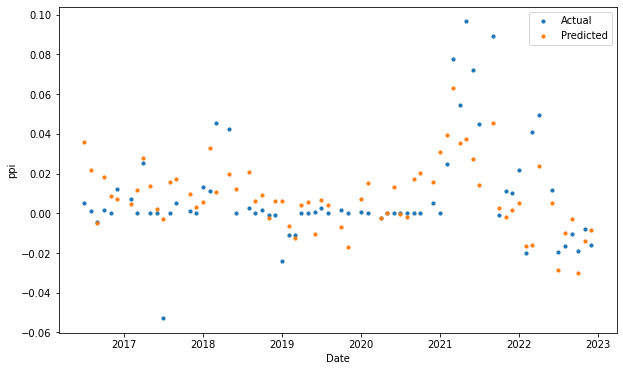

In [ ]:
import matplotlib.pyplot as plt

# Make predictions using the model
log_diff_df['y_hat'] = model.predict(x)

# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(log_diff_df['Date'], log_diff_df['log_diff_ppi'], label='Actual', s=10)
ax.scatter(log_diff_df['Date'], log_diff_df['y_hat'], label='Predicted', s=10)

# Add labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('ppi')
ax.legend()

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('ppi')
plt.legend()

# Show plot
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# set y variable
y = log_diff_df['log_diff_ppi']

# Define x variables
x_cols = [col for col in log_diff_df.columns if col in ['log_diff_price_hrc', 'log_diff_price_hrc_lag1', 'log_diff_price_hrc_lag4', 'log_diff_price_scrap', 'log_diff_price_scrap_lag3']]
X = log_diff_df[x_cols]

# scale to compare to L1 regularization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Add constant to x variables
X = sm.add_constant(X)

# Fit linear regression model
model = sm.OLS(y, X).fit()

# Print model summary
print(model.summary())

# make predictions on X_test using the fitted model
y_pred = model.predict(X)

# calculate the mean squared error between the predicted and true target values
mse = mean_squared_error(y, y_pred)

# print the MSE
print('MSE:', mse)

                            OLS Regression Results                            
Dep. Variable:           log_diff_ppi   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     7.755
Date:                Mon, 13 Mar 2023   Prob (F-statistic):           1.02e-05
Time:                        15:44:53   Log-Likelihood:                 169.03
No. Observations:                  68   AIC:                            -326.1
Df Residuals:                      62   BIC:                            -312.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0084      0.003      3.299      0.0

### Lasso model: 

Let's experiment with Type 1 regularization. We can use this to identify the most relevant variables, 

In [ ]:
# start by splitting the dataframe into test and train

from sklearn.model_selection import train_test_split

# set y variable
y = log_diff_df['log_diff_ppi']

# Define x variables
x_cols = [col for col in log_diff_df.columns if col not in ['log_diff_ppi', 'Date']]
x = log_diff_df[x_cols]

# Add constant to x variables
x = sm.add_constant(x)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1738)

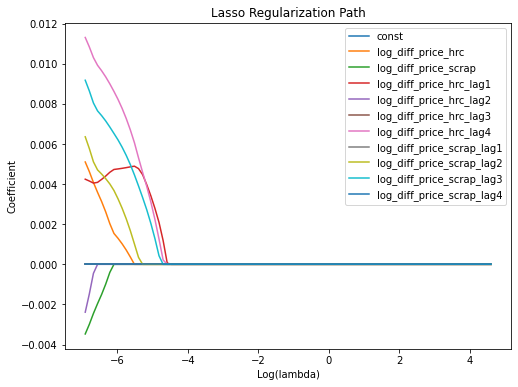

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Define your X and y variables
X = x_train
y = y_train

# Scale your X variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the range of lambda values to test
lambda_values = np.logspace(-3, 2, 100)

# Create an empty array to store the coefficients
coefficients = np.zeros((X.shape[1], len(lambda_values)))

# Fit the Lasso regression for each value of lambda and store the coefficients
for i, lambda_val in enumerate(lambda_values):
    lasso = Lasso(alpha=lambda_val)
    lasso.fit(X_scaled, y)
    coefficients[:, i] = lasso.coef_

# Plot the coefficients vs log(lambda)
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(X.shape[1]):
    ax.plot(np.log(lambda_values), coefficients[i], label=X.columns.values[i])
ax.legend()
ax.set_xlabel("Log(lambda)")
ax.set_ylabel("Coefficient")
ax.set_title("Lasso Regularization Path")
plt.show()


Find the optimal lambda value: 

In [ ]:
max_index = np.argmax(coefficients[3,:])
max_index = np.argmax(coefficients[3,:])

print(coefficients[3, max_index])
print("Index with the maximum value in column 4:", max_index)
print("Optimal lambda:", lambda_values[max_index])
print("Optimal coefficients:", coefficients[:,max_index])

0.004892554099669969
Index with the maximum value in column 4: 12
Optimal lambda: 0.004037017258596553
Optimal coefficients: [ 0.          0.         -0.          0.00489255  0.          0.
  0.00606187  0.          0.0010155   0.004458    0.        ]


Fit the model on the optimal lambda and try it on the train dataset: 

In [ ]:
lasso = Lasso(alpha=lambda_values[max_index])
lasso.fit(X_scaled, y)

# get the summary of the Lasso fit
summary = pd.Series(lasso.coef_, index=X.columns, name='Coefficient')
summary['intercept'] = lasso.intercept_
summary['R^2'] = lasso.score(X_scaled, y)

# test it
x_test_scaled = scaler.transform(x_test)
# predict y_hat using the scaled x_test
y_hat = lasso.predict(x_test_scaled)
#log_result_df['y_hat_lm'] = y_hat  

print(summary)

const                        0.000000
log_diff_price_hrc           0.000000
log_diff_price_scrap        -0.000000
log_diff_price_hrc_lag1      0.004893
log_diff_price_hrc_lag2      0.000000
log_diff_price_hrc_lag3      0.000000
log_diff_price_hrc_lag4      0.006062
log_diff_price_scrap_lag1    0.000000
log_diff_price_scrap_lag2    0.001015
log_diff_price_scrap_lag3    0.004458
log_diff_price_scrap_lag4    0.000000
intercept                    0.009558
R^2                          0.308446
Name: Coefficient, dtype: float64


Get the MSE on test and train: 

In [ ]:
from sklearn.metrics import mean_squared_error
from scipy.stats.stats import pearsonr   

# Assuming X_train, y_train, X_test, y_test are the train-test split data
# and lasso is the fitted Lasso model
y_pred_train = lasso.predict(X_scaled)
mse = mean_squared_error(y_train, y_pred_train)
print("Mean squared error train: ", mse)

scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(x_test)
y_pred_test = lasso.predict(x_test_scaled)

#correlation coefficient
print("Pearpearsonr(y_test, y_pred_test))
mse = mean_squared_error(y_test, y_pred_test)
print("Mean squared error test: ", mse)

Mean squared error train:  0.0004885978186065671
PearsonRResult(statistic=0.6146836277557763, pvalue=0.01932579642442682)
Mean squared error test:  0.0003096684664150004


<ipython-input-60-c31457dfb926>:2: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


### 3: A time-series approach
Perhaps the PPI is affected by past changes in the price of different instruments. Price hikes take time to ripple through a supply chain, so analying the lags of our data might make sense. To do this, we will introduce two approaches: an autoregressive model (AR) and its more sophisticated counterpart, an ARIMA model. 

Let's start by observing whether the price or the log_returns are stationary using the Automated Dickey Fuller test

In [ ]:
from statsmodels.tsa.stattools import adfuller
print("ADF Price data:", adfuller(merged_df['ppi'])[1])
print("ADF Log returns:", adfuller(log_diff_df['log_diff_ppi'])[1])

Price data: 0.7934294815771687
Log returns: 0.0482600949475846


The price data is clearly non-stationary, and we can model it using an AR model: 

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

# set y variable
y = ppi_fabricated_steel['ppi']

# Define x variables
x_cols = [col for col in merged_df.columns if col not in ['ppi', 'Date']]
x = merged_df[x_cols]

# fit an AR(2) model
model = AutoReg(y, lags=2)
result = model.fit()

# print the summary of the model
print(result.summary())


                            AutoReg Model Results                             
Dep. Variable:                    ppi   No. Observations:                  140
Model:                     AutoReg(2)   Log Likelihood                -303.811
Method:               Conditional MLE   S.D. of innovations              2.187
Date:                Fri, 10 Mar 2023   AIC                            615.623
Time:                        18:35:28   BIC                            627.332
Sample:                    08-01-2011   HQIC                           620.381
                         - 01-01-2023                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4600      0.792      0.581      0.561      -1.092       2.012
ppi.L1         1.6275      0.068     23.920      0.000       1.494       1.761
ppi.L2        -0.6293      0.069     -9.079      0.0

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


**ARIMA model:**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# set x and y variables
y = log_diff_df.iloc[:, 3]  
x = log_diff_df.iloc[:, 1:3]

# define the model
model = ARIMA(y, order=(2,1,1), exog=x)

# fit the model
model_fit = model.fit()

# print the summary of the model
print(model_fit.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zero

                               SARIMAX Results                                
Dep. Variable:         log_diff_index   No. Observations:                   17
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  15.259
Date:                Thu, 09 Mar 2023   AIC                            -18.519
Time:                        18:26:17   BIC                            -13.883
Sample:                             0   HQIC                           -18.281
                                 - 17                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
log_diff_price.hrc       0.3310      0.498      0.664      0.507      -0.646       1.308
log_diff_price.scrap    -0.1495      0.383     -0.390      0.697      -0.901       0.602
ar.L1       

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
